In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content


In [2]:
#importing libraries
import numpy as np 
import pandas as pd 
import os
from statsmodels import api as sm
import pylab as py
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy.stats import kstest,norm
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics
from scipy.stats import chi2_contingency
#import pandas_profiling

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'object']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
df = pd.read_csv('/content/drive/MyDrive/2019-Oct.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42448764 entries, 0 to 42448763
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.8+ GB


In [5]:
dup_items = set()
uniq_items = []
for x in df:
  if x not in dup_items:
    uniq_items.append(x)
    dup_items.add(x)
    print(dup_items)

{'event_time'}
{'event_time', 'event_type'}
{'event_time', 'event_type', 'product_id'}
{'event_time', 'event_type', 'product_id', 'category_id'}
{'product_id', 'category_code', 'event_time', 'event_type', 'category_id'}
{'product_id', 'category_code', 'brand', 'event_time', 'event_type', 'category_id'}
{'product_id', 'category_code', 'brand', 'price', 'event_time', 'event_type', 'category_id'}
{'product_id', 'category_code', 'brand', 'user_id', 'price', 'event_time', 'event_type', 'category_id'}
{'product_id', 'user_session', 'category_code', 'brand', 'user_id', 'price', 'event_time', 'event_type', 'category_id'}


In [5]:
df.isnull()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
42448759,False,False,False,False,False,False,False,False,False
42448760,False,False,False,False,True,False,False,False,False
42448761,False,False,False,False,False,False,False,False,False
42448762,False,False,False,False,False,False,False,False,False


In [6]:
df.isnull().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand             6117080
price                   0
user_id                 0
user_session            2
dtype: int64

In [ ]:
#df.drop_duplicates(subset= ['event_type'])

In [5]:
# remove irrelevant column
df = df.drop([ 'category_code'], axis = 1)
df

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
...,...,...,...,...,...,...,...,...
42448759,2019-10-31 23:59:58 UTC,view,2300275,2053013560530830019,gopro,527.40,537931532,22c57267-da98-4f28-9a9c-18bb5b385193
42448760,2019-10-31 23:59:58 UTC,view,10800172,2053013554994348409,redmond,61.75,527322328,5054190a-46cb-4211-a8f1-16fc1a060ed8
42448761,2019-10-31 23:59:58 UTC,view,5701038,2053013553970938175,kenwood,128.70,566280422,05b6c62b-992f-4e8e-91f7-961bcb4719cd
42448762,2019-10-31 23:59:59 UTC,view,21407424,2053013561579406073,tissot,689.85,513118352,4c14bf2a-2820-4504-929d-046356a5a204


In [6]:
df.duplicated()

0           False
1           False
2           False
3           False
4           False
            ...  
42448759    False
42448760    False
42448761    False
42448762    False
42448763    False
Length: 42448764, dtype: bool

In [7]:
df.drop_duplicates()

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
...,...,...,...,...,...,...,...,...
42448759,2019-10-31 23:59:58 UTC,view,2300275,2053013560530830019,gopro,527.40,537931532,22c57267-da98-4f28-9a9c-18bb5b385193
42448760,2019-10-31 23:59:58 UTC,view,10800172,2053013554994348409,redmond,61.75,527322328,5054190a-46cb-4211-a8f1-16fc1a060ed8
42448761,2019-10-31 23:59:58 UTC,view,5701038,2053013553970938175,kenwood,128.70,566280422,05b6c62b-992f-4e8e-91f7-961bcb4719cd
42448762,2019-10-31 23:59:59 UTC,view,21407424,2053013561579406073,tissot,689.85,513118352,4c14bf2a-2820-4504-929d-046356a5a204


In [ ]:
df.drop_duplicates(subset= ['event_type'])

,event_time,event_type,product_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
162,2019-10-01 00:02:14 UTC,purchase,1004856,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564
331,2019-10-01 00:05:14 UTC,cart,5100816,NaN,xiaomi,29.51,550121407,6f623695-9581-4633-813f-825b8760c7ae


In [8]:
#Basic information

df.info()

#Describe the data

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42448764 entries, 0 to 42448763
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   event_time    object 
 1   event_type    object 
 2   product_id    int64  
 3   category_id   int64  
 4   brand         object 
 5   price         float64
 6   user_id       int64  
 7   user_session  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 2.5+ GB


,product_id,category_id,price,user_id
count,4.244876e+07,4.244876e+07,4.244876e+07,4.244876e+07
mean,1.054993e+07,2.057404e+18,2.903237e+02,5.335371e+08
std,1.188191e+07,1.843926e+16,3.582692e+02,1.852374e+07
min,1.000978e+06,2.053014e+18,0.000000e+00,3.386938e+07
25%,1.005157e+06,2.053014e+18,6.598000e+01,5.159043e+08
50%,5.000470e+06,2.053014e+18,1.629300e+02,5.296965e+08
75%,1.600030e+07,2.053014e+18,3.585700e+02,5.515788e+08
max,6.050001e+07,2.175420e+18,2.574070e+03,5.662809e+08


In [ ]:
#Find the duplicates

#df.duplicated().sum()

In [ ]:
#df = list(set(''))

#print("The List after removing duplicates:" +str(df))
#df.drop_duplicates(subset='event_type', keep=false,inplace)

In [ ]:
#df.drop_duplicates(subset =  ['event_time', 'event_type', 'product_id', 'category_code', 'category_id', 'brand', 'price', 'user_id', 'user_session'])

In [6]:
# Count null features in the dataset
df.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
brand           6117080
price                 0
user_id               0
user_session          2
dtype: int64

In [7]:
# Replace the null features with 0:
df.fillna(0, inplace=True) # Re-check N/A was replaced with 0.

In [ ]:
#df.duplicated()

In [11]:
# Exploring data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42448764 entries, 0 to 42448763
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   event_time    object 
 1   event_type    object 
 2   product_id    int64  
 3   category_id   int64  
 4   brand         object 
 5   price         float64
 6   user_id       int64  
 7   user_session  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 2.5+ GB


In [13]:
#unique values

df['product_id'].unique()

df['category_id'].unique()

df['user_id'].unique()

array([541312140, 554748717, 519107250, ..., 539701280, 566280860,
       544578298])

In [8]:
df.drop_duplicates(subset= ['price'])

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,0,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
...,...,...,...,...,...,...,...,...
42437036,2019-10-31 22:27:18 UTC,view,4201382,2053013552351936731,aux,1688.81,519594980,2683ba21-8ff2-4b73-94ea-22a716d060e4
42437105,2019-10-31 22:27:51 UTC,view,4200480,2053013552351936731,almacom,1693.42,519594980,2683ba21-8ff2-4b73-94ea-22a716d060e4
42437280,2019-10-31 22:28:58 UTC,view,4201549,2053013552351936731,gree,1604.37,519594980,2683ba21-8ff2-4b73-94ea-22a716d060e4
42447876,2019-10-31 23:53:13 UTC,view,47000083,2110937189394154243,canon,1667.47,512416379,4dfe2c67-e537-4dc2-ae69-0b65263db091


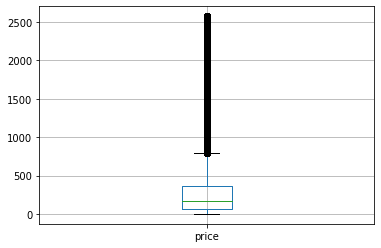

In [11]:
#Boxplot

df[['price']].boxplot()

In [12]:
#Correlation 

df.corr()

,product_id,category_id,price,user_id
product_id,1.000000,0.470864,-0.233352,-0.032483
category_id,0.470864,1.000000,-0.026354,-0.009287
price,-0.233352,-0.026354,1.000000,0.003399
user_id,-0.032483,-0.009287,0.003399,1.000000


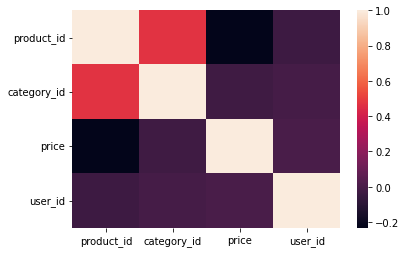

In [17]:
#Correlation plot

sns.heatmap(df.corr())

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42448764 entries, 0 to 42448763
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   event_time    object 
 1   event_type    object 
 2   product_id    int64  
 3   category_id   int64  
 4   brand         object 
 5   price         float64
 6   user_id       int64  
 7   user_session  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 2.5+ GB


In [ ]:
df['brand'].value_counts()
df['event_type'].value_counts()

view        40779399
cart          926516
purchase      742849
Name: event_type, dtype: int64

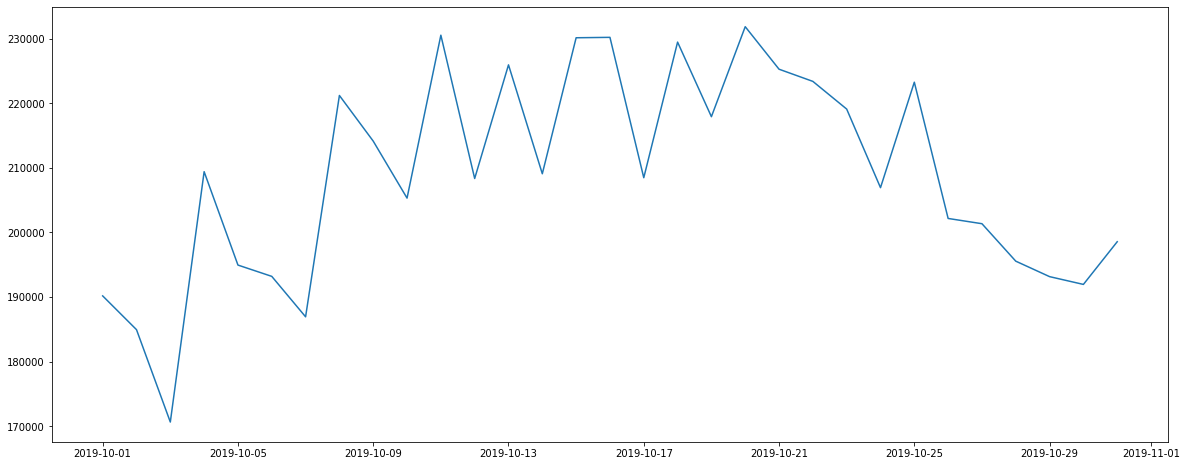

In [ ]:
#No of visitors by date
data = df.loc[:,['event_time','user_id']]
#Extracting only dates
data['event_time'] = data['event_time'].apply(lambda s: str(s)[0:10])
visitor_by_date = data.drop_duplicates().groupby(['event_time'])['user_id'].agg(['count']).sort_values(by=['event_time'], ascending=True)
x = pd.Series(visitor_by_date.index.values).apply(lambda s: datetime.strptime(s, '%Y-%m-%d').date())
y = visitor_by_date['count']
plt.rcParams['figure.figsize'] = (20,8)

plt.plot(x,y)
plt.show()


In [ ]:
title_type = df.groupby('brand').agg('count')
print(title_type)
type_labels = title_type.user_id.sort_values().index
type_counts = title_type.user_id.sort_values()
plt.figure(1,figsize =(20,10))
the_grid = GridSpec(2,2)
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0,1,8)]
plt.subplot(the_grid[0,1],aspect=1,title = 'Brand titles')
type_show_ids = plt.pie(type_counts,labels = type_labels,autopct = '%1.1f%%',shadow = True,colors = colors)
plt.show()

In [ ]:
# remove irrelevant column
#df = df.drop(['category_code', 'user_session','event_time'], axis = 1)
df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,0,shiseido,35.78125,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.18750,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,0,543.00000,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.75000,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1082.00000,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
...,...,...,...,...,...,...,...,...,...
42448759,2019-10-31 23:59:58 UTC,view,2300275,2053013560530830019,electronics.camera.video,gopro,527.50000,537931532,22c57267-da98-4f28-9a9c-18bb5b385193
42448760,2019-10-31 23:59:58 UTC,view,10800172,2053013554994348409,0,redmond,61.75000,527322328,5054190a-46cb-4211-a8f1-16fc1a060ed8
42448761,2019-10-31 23:59:58 UTC,view,5701038,2053013553970938175,auto.accessories.player,kenwood,128.75000,566280422,05b6c62b-992f-4e8e-91f7-961bcb4719cd
42448762,2019-10-31 23:59:59 UTC,view,21407424,2053013561579406073,electronics.clocks,tissot,690.00000,513118352,4c14bf2a-2820-4504-929d-046356a5a204


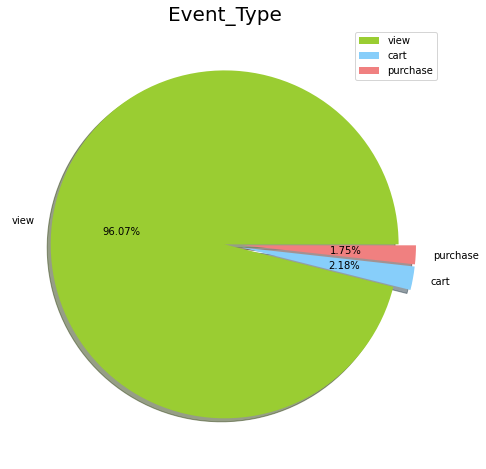

In [13]:
labels = ['view', 'cart','purchase']
size = df['event_type'].value_counts()
colors = ['yellowgreen', 'lightskyblue','lightcoral']
explode = [0, 0.1,0.1]

plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Event_Type', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

In [ ]:
# Group by User ID:
purchases = df.groupby(['user_id']).sum().reset_index()

In [ ]:
Price_by_Product_id = df.groupby('product_id')['price'].mean().reset_index()

In [ ]:
view_count = df['event_type'].value_counts()[0]
cart_count = df['event_type'].value_counts()[1]
purchase_count = df['event_type'].value_counts()[2]
print("Rate of conversion between view and purchase events" +str((purchase_count/view_count)*100) +'%')
print("Rate of conversion between view and add to cart events" +str((cart_count/view_count)*100) +'%')
print("Rate of conversion between add to cart and purchase events" +str((purchase_count/cart_count)*100) +'%')

Rate of conversion between view and purchase events1.821628121591493%
Rate of conversion between view and add to cart events2.2720197519340584%
Rate of conversion between add to cart and purchase events80.17659705822673%


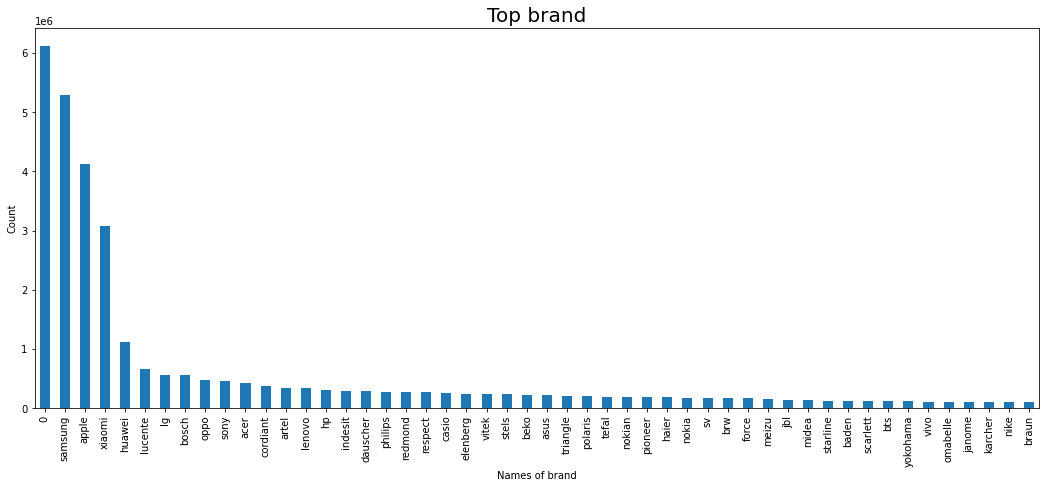

In [14]:
#Brandwise sales of all event types
df['brand'].value_counts().head(50).plot.bar(figsize = (18,7))
plt.title('Top brand',fontsize = 20)
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show()

samsung        172878
apple          142858
0               58301
xiaomi          56609
huawei          23499
                ...  
brevi               1
feron               1
chaod               1
berber              1
trendbeauty         1
Name: brand, Length: 1984, dtype: int64


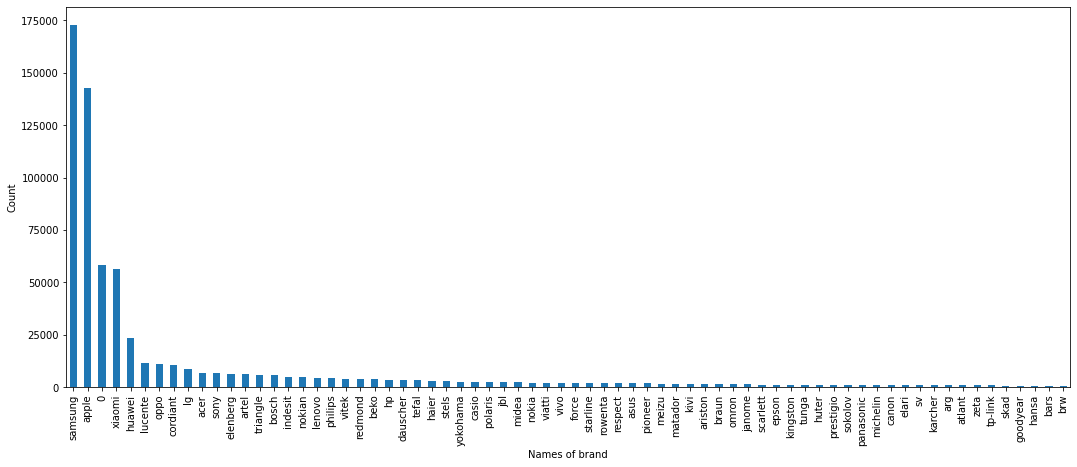

In [ ]:
d = df.loc[df['event_type'].isin(['purchase'])].drop_duplicates()
print(d['brand'].value_counts())
d['brand'].value_counts().head(70).plot.bar(figsize =(18,7))
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show()

In [ ]:
#List of people who has bought or added products to the cart
cart_purchase_users = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['user_id'])
cart_purchase_users.dropna(how='any', inplace=True)
print(cart_purchase_users)

                       event_time event_type  product_id          category_id  \
162       2019-10-01 00:02:14 UTC   purchase     1004856  2053013555631882655   
308       2019-10-01 00:04:37 UTC   purchase     1002532  2053013555631882655   
331       2019-10-01 00:05:14 UTC       cart     5100816  2053013553375346967   
379       2019-10-01 00:06:02 UTC   purchase     5100816  2053013553375346967   
442       2019-10-01 00:07:07 UTC   purchase    13800054  2053013557418656265   
...                           ...        ...         ...                  ...   
42447323  2019-10-31 23:48:35 UTC       cart    12705003  2053013553559896355   
42447440  2019-10-31 23:49:30 UTC   purchase     1003316  2053013555631882655   
42447449  2019-10-31 23:49:32 UTC   purchase     1002524  2053013555631882655   
42447581  2019-10-31 23:50:34 UTC       cart     1005256  2053013555631882655   
42448124  2019-10-31 23:55:07 UTC       cart     1005134  2053013555631882655   

                      categ

In [ ]:
cart_purchase_users_all_activity = df.loc[df['user_id'].isin(cart_purchase_users['user_id'])]
print(cart_purchase_users_all_activity)

                       event_time event_type  product_id          category_id  \
0         2019-10-01 00:00:00 UTC       view    44600062  2103807459595387724   
5         2019-10-01 00:00:05 UTC       view     1480613  2053013561092866779   
13        2019-10-01 00:00:15 UTC       view    44600062  2103807459595387724   
22        2019-10-01 00:00:22 UTC       view     1480714  2053013561092866779   
23        2019-10-01 00:00:23 UTC       view     1004739  2053013555631882655   
...                           ...        ...         ...                  ...   
42448739  2019-10-31 23:59:52 UTC       view     5100767  2053013553375346967   
42448740  2019-10-31 23:59:52 UTC       view     1002524  2053013555631882655   
42448741  2019-10-31 23:59:53 UTC       view    17200505  2053013559792632471   
42448747  2019-10-31 23:59:54 UTC       view    25600078  2053013559675191951   
42448749  2019-10-31 23:59:55 UTC       view     5800263  2053013553945772349   

                        cat

In [ ]:
activity_in_session = cart_purchase_users_all_activity.groupby(['user_id'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type":"activity_count"})
print(activity_in_session)

          user_id  activity_count
0       264649825              23
1       284344819               4
2       293957954              11
3       303160429               3
4       304325717              16
...           ...             ...
481453  566272904               2
481454  566274637               3
481455  566276996               6
481456  566278294               4
481457  566280291               3

[481458 rows x 2 columns]


In [ ]:
activity_in_session = cart_purchase_users_all_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type":"activity_count"})
print(activity_in_session)

                                 user_session  activity_count
0                                           0               2
1        00000083-8816-4d58-a9b8-f52f54186edc              18
2        000001fd-1f89-45e8-a3ce-fe3218cabfad              11
3        000003eb-b63e-45d9-9f26-f229057c654a               1
4        00000809-9101-4e4b-9795-e6cbafccfe19               4
...                                       ...             ...
3251770  ffffd89d-208c-28ec-da2f-6668c878fffc               1
3251771  ffffdf58-84cb-4337-a802-061db4843e54               1
3251772  ffffe0a4-b8a3-47d7-8d08-682f7870135c               4
3251773  ffffe3ba-7c09-4c3a-a8fe-75ba46b1e146               2
3251774  fffff8d4-d31c-4066-a00b-2ace84d33640              12

[3251775 rows x 2 columns]


In [ ]:
def convert_time_to_date(utc_timestamp):
  utc_date = datetime.strptime(utc_timestamp[0:10],'%Y-%m-%d').date()
  return utc_date

In [ ]:
toprocks = ['event_type']
df_toprocks = df[df['brand'].isin(toprocks)]

In [ ]:
#List of people who has bought or added products to the cart
cart_purchase_users = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['user_id'])
cart_purchase_users.dropna(how='any', inplace=True)
print(cart_purchase_users)

                       event_time event_type  product_id          category_id  \
162       2019-10-01 00:02:14 UTC   purchase     1004856  2053013555631882655   
308       2019-10-01 00:04:37 UTC   purchase     1002532  2053013555631882655   
331       2019-10-01 00:05:14 UTC       cart     5100816  2053013553375346967   
379       2019-10-01 00:06:02 UTC   purchase     5100816  2053013553375346967   
442       2019-10-01 00:07:07 UTC   purchase    13800054  2053013557418656265   
...                           ...        ...         ...                  ...   
42447323  2019-10-31 23:48:35 UTC       cart    12705003  2053013553559896355   
42447440  2019-10-31 23:49:30 UTC   purchase     1003316  2053013555631882655   
42447449  2019-10-31 23:49:32 UTC   purchase     1002524  2053013555631882655   
42447581  2019-10-31 23:50:34 UTC       cart     1005256  2053013555631882655   
42448124  2019-10-31 23:55:07 UTC       cart     1005134  2053013555631882655   

                      categ

In [ ]:
cart_purchase_users_all_activity = df.loc[df['user_id'].isin(cart_purchase_users['user_id'])]
print(cart_purchase_users_all_activity)

                       event_time event_type  product_id          category_id  \
0         2019-10-01 00:00:00 UTC       view    44600062  2103807459595387724   
5         2019-10-01 00:00:05 UTC       view     1480613  2053013561092866779   
13        2019-10-01 00:00:15 UTC       view    44600062  2103807459595387724   
22        2019-10-01 00:00:22 UTC       view     1480714  2053013561092866779   
23        2019-10-01 00:00:23 UTC       view     1004739  2053013555631882655   
...                           ...        ...         ...                  ...   
42448739  2019-10-31 23:59:52 UTC       view     5100767  2053013553375346967   
42448740  2019-10-31 23:59:52 UTC       view     1002524  2053013555631882655   
42448741  2019-10-31 23:59:53 UTC       view    17200505  2053013559792632471   
42448747  2019-10-31 23:59:54 UTC       view    25600078  2053013559675191951   
42448749  2019-10-31 23:59:55 UTC       view     5800263  2053013553945772349   

                        cat

In [ ]:
activity_in_session = cart_purchase_users_all_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type":"activity_count"})
print(activity_in_session)

                                 user_session  activity_count
0                                           0               2
1        00000083-8816-4d58-a9b8-f52f54186edc              18
2        000001fd-1f89-45e8-a3ce-fe3218cabfad              11
3        000003eb-b63e-45d9-9f26-f229057c654a               1
4        00000809-9101-4e4b-9795-e6cbafccfe19               4
...                                       ...             ...
3251770  ffffd89d-208c-28ec-da2f-6668c878fffc               1
3251771  ffffdf58-84cb-4337-a802-061db4843e54               1
3251772  ffffe0a4-b8a3-47d7-8d08-682f7870135c               4
3251773  ffffe3ba-7c09-4c3a-a8fe-75ba46b1e146               2
3251774  fffff8d4-d31c-4066-a00b-2ace84d33640              12

[3251775 rows x 2 columns]


In [ ]:
def convert_time_to_date(utc_timestamp):
  utc_date = datetime.strptime(utc_timestamp[0:10],'%Y-%m-%d').date()
  return utc_date

In [ ]:
df['event_date'] = df['event_time'].apply(lambda s:convert_time_to_date(s))